<center><img src='https://i.postimg.cc/TPR1n1rp/AI-Tech-PL-RGB.png' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://i.postimg.cc/Gpq2KRQz/logotypy-aitech.jpg'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
</center>

# Lab 06: Soft Actor-Critic

This lab looks into solving a continuous control problem using the actor-critic method: Soft Actor-Critic (SAC)

- Given the environment, that you can rollout, find a policy $\pi(a | s)$ that maximizes the objective and the actions entropy.
- The latter shall ensure policy robustnes to disturbances in the environment.

We solve the Pendulum problem, shown below, in following steps

1. Define the actor-critic's models,
2. Implement the SAC's update,
3. Train and visualize the policy.

Code based on: https://github.com/awarelab/spinningup_tf2

In [1]:
# Installing dependencies for visualization
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'


In [2]:
import glob
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from base64 import b64encode
from IPython.display import HTML
from pyvirtualdisplay import Display

# Start virtual display
display = Display(visible=0, size=(1024, 768))
display.start()

# Seed random generators
tf.random.set_seed(42)
np.random.seed(42)

# Parameters
hidden_sizes=(64, 64) # Actor and critic networks sizes
total_steps=20_000 # Number of environment interactions to run and train on
replay_size=20_000 # Maximum length of replay buffer
gamma=0.99 # Discount factor (Always between 0 and 1.)
polyak=0.995 # Interpolation factor in polyak averaging for target networks
lr=0.001 # Learning rate (used for both policy and value learning)
alpha=0.2 # Entropy regularization coefficient (Equivalent to inverse of reward scale in the original SAC paper)
batch_size=256 # Minibatch size for SGD
start_steps=1_000 # Warm-up steps (uniform-random actions) before running real policy
update_after=512 # Number of env interactions to collect before starting to do gradient descent updates (Ensures replay buffer is full enough for useful updates)
update_every=50 # Number of env interactions that should elapse between gradient descent updates
max_ep_len=200 # Maximum length of trajectory / episode / rollout
num_test_episodes=30 # Number of episodes to test the deterministic policy at the end of training

# Constants
EPS = 1e-8

LOG_STD_MAX = 2
LOG_STD_MIN = -20

# Helpers

def show_video(file_name):
    mp4 = open(file_name,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=480 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

class ReplayBuffer:
    """A simple FIFO experience replay buffer for SAC agents."""

    def __init__(self, obs_dim, act_dim, size):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=tf.convert_to_tensor(self.obs1_buf[idxs]),
                    obs2=tf.convert_to_tensor(self.obs2_buf[idxs]),
                    acts=tf.convert_to_tensor(self.acts_buf[idxs]),
                    rews=tf.convert_to_tensor(self.rews_buf[idxs]),
                    done=tf.convert_to_tensor(self.done_buf[idxs]))

# 0. The Pendulum environment

- The goal is to flip and balance the pendulum straight upwards.
- The observations are cosine and sine of the pendulum angular position, and its angular velocity.
- The actions is torque at the joint.
- The reward is the sum of the cost for the deviation from the zero position and velocity, and the action cost.
    Therefore, it's always negative and we want to minimize it.

Below is the video presenting random policy acting on the pendulum.

In [3]:
env = gym.make('Pendulum-v0')
envw = gym.wrappers.Monitor(env, "./", force=True)
o, d, ep_len = envw.reset(), False, 0
while not (d or (ep_len == max_ep_len)):
    envw.render()
    o, r, d, info = envw.step(envw.action_space.sample())
envw.close()

In [4]:
file_name = glob.glob('openaigym.video.*.mp4')[0]
show_video(file_name)

# 1. Define the actor-critic's models

In [5]:
# Helper functions

def gaussian_likelihood(value, mu, log_std):
    """Calculates value's likelihood under Gaussian pdf."""
    pre_sum = -0.5 * (
        ((value - mu) / (tf.exp(log_std) + EPS)) ** 2 +
        2 * log_std + np.log(2 * np.pi)
    )
    return tf.reduce_sum(pre_sum, axis=1)


def apply_squashing_func(mu, pi, logp_pi):
    """Applies adjustment to mean, pi and log prob.

    This formula is a little bit magic. To get an understanding of where it
    comes from, check out the original SAC paper (arXiv 1801.01290) and look
    in appendix C. This is a more numerically-stable equivalent to Eq 21.
    Try deriving it yourself as a (very difficult) exercise. :)
    """
    logp_pi -= tf.reduce_sum(
        2 * (np.log(2) - pi - tf.nn.softplus(-2 * pi)), axis=1)

    # Squash those unbounded actions!
    mu = tf.tanh(mu)
    pi = tf.tanh(pi)
    return mu, pi, logp_pi


def mlp(hidden_sizes, activation, name=None):
    """Create the Multi-Layer Perceptron model."""
    return tf.keras.Sequential([
        tf.keras.layers.Dense(size, activation=activation)
        for size in hidden_sizes
    ], name)

## SAC's actor model

- We model the policy with the Gaussian distribution parametrized with a mean and a standard deviation conditioned on the current state.

  $$a \sim \mathcal{N}(\mu, \sigma | s)$$

- The model needs to return
  - A sample action from the normal distribution - used as the explorative action.
  - A normal distribution mean - used as the explitative action.
  - The log likelihood of the sample action - used in the max-entropy objective.
- However, because the actions are bound, we need to apply a squashing function `tanh` on the sample action and the mean which also changes the action's likelihood. There is a helper function already implemented for this task: `apply_squashing_func`.
- We use the MLP function approximator to model the policy.

### Exercise

Answer: What is the network output?

> Answer: ...

In [10]:
def make_actor(observation_space, action_space,
               hidden_sizes=(256, 256),
               activation=tf.nn.relu):
    """Create the actor's tf.keras.Model."""
    obs_dim = observation_space.shape[0]
    act_dim = action_space.shape[0]
    act_scale = action_space.high[0]

    obs_input = tf.keras.Input(shape=(obs_dim,))

    # Exercise: Define the actor's model
    body = mlp(hidden_sizes=hidden_sizes, activation=activation)(obs_input)
    mu = tf.keras.layers.Dense(act_dim)(body)
    log_std = tf.keras.layers.Dense(act_dim)(body)

    # Note: Clip the log std. dev. between [LOG_STD_MIN, LOG_STD_MAX].

    log_std = tf.clip_by_value(log_std, LOG_STD_MIN, LOG_STD_MAX)
    std = tf.exp(log_std)
    pi = mu + tf.random.normal(tf.shape(input=mu)) * std
    logp_pi = gaussian_likelihood(pi, mu, log_std)

    mu, pi, logp_pi = apply_squashing_func(mu, pi, logp_pi)

    # Make sure actions are in the correct range
    mu *= act_scale
    pi *= act_scale

    return tf.keras.Model(inputs=obs_input, outputs=[mu, pi, logp_pi])

In [11]:
# TEST
_actor = make_actor(env.observation_space, env.action_space, hidden_sizes)

assert len(_actor.inputs) == 1
assert _actor.inputs[0].shape.as_list() == [None, 3]

assert len(_actor.outputs) == 3
assert _actor.outputs[0].shape.as_list() == [None, 1]
assert _actor.outputs[1].shape.as_list() == [None, 1]
assert _actor.outputs[2].shape.as_list() == [None]

# Two hidden layers should have 64 units each
# assert _actor.layers[1].output.shape.as_list() == [None, 64]

## SAC's critic model

We model the quality function with the MLP function approximator that takes a pair of state and action as an input and returns its value.

  $$Q(s, a) = \textrm{MLP}(s, a)$$

### Exercise

Answer: What is the network output's shape?

> Answer: ...

In [20]:
def make_critic(observation_space, action_space,
                hidden_sizes=(256, 256),
                activation=tf.nn.relu):
    """Create the critic's tf.keras.Model."""
    obs_dim = observation_space.shape[0]
    act_dim = action_space.shape[0]

    obs_input = tf.keras.Input(shape=(obs_dim,))
    act_input = tf.keras.Input(shape=(act_dim,))
    concat_input = tf.keras.layers.Concatenate(axis=-1)([obs_input, act_input])

    # Exercise: Define the critic's model

    value = tf.keras.Sequential([
        mlp(hidden_sizes, activation),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Reshape([])
    ])(concat_input)

    return tf.keras.Model(inputs=[obs_input, act_input], outputs=value)

In [21]:
# TEST
_critic = make_critic(env.observation_space, env.action_space, hidden_sizes)

assert len(_critic.inputs) == 2
assert _critic.inputs[0].shape.as_list() == [None, 3]
assert _critic.inputs[1].shape.as_list() == [None, 1]

assert len(_critic.outputs) == 1
assert _critic.outputs[0].shape.as_list() == [None]

# Two hidden layers should have 64 units each
# assert _critic.layers[1].output.shape.as_list() == [None, 64]

# 2. Implement the SAC's update

We define the actor-critic losses as follows

_Input:_ policy $\pi$; policy parameters $\theta$; Q-function $Q$; Q-function parameters $\phi_1$, $\phi_2$; target parameters $\phi_{\text{targ},1}$, $\phi_{\text{targ},2}$;

1. Compute targets for the quality functions.  
Note that we sample the next action $\tilde{a}'$ - don't use some from the replay buffer.

$$
\begin{aligned}
y(r,s',d) &= r + \gamma (1-d) \left(\min_{i=1,2} Q_{\phi_{\text{targ}, i}} (s', \tilde{a}') - \alpha \log \pi_{\theta}(\tilde{a}'|s')\right), && \tilde{a}' \sim \pi_{\theta}(\cdot|s')
\end{aligned}
$$

2. Compute the loss for each quality function.

$$
\begin{aligned}
\frac{1}{|B|}\sum_{(s,a,r,s',d) \in B} \left( Q_{\phi_i}(s,a) - y(r,s',d) \right)^2 && \text{for } i=1,2
\end{aligned}
$$

3. Compute the policy loss.  
Note that we sample the action $\tilde{a}_\theta$ so its differentiable with respect to its parameters $\theta$ via the reparametrization trick.

$$
\begin{aligned}
\frac{1}{|B|}\sum_{s \in B} \Big(\min_{i=1,2} Q_{\phi_i}(s, \tilde{a}_{\theta}(s)) - \alpha \log \pi_{\theta} \left(\left. \tilde{a}_{\theta}(s) \right| s\right) \Big)
\end{aligned}
$$


The target networks parameters, $\phi_{\text{targ}, i}$, are updated using the polyak averaging, where $\rho$ is the interpolation factor.

$$
\begin{aligned}
\phi_{\text{targ},i} &\leftarrow \rho \phi_{\text{targ}, i} + (1-\rho) \phi_i && \text{for } i=1,2
\end{aligned}
$$

In [22]:
@tf.function
def learn_on_batch(obs1, obs2, acts, rews, done):
    with tf.GradientTape(persistent=True) as g:
        # Main outputs from computation graph.
        _, pi, logp_pi = actor(obs1)
        q1 = critic1([obs1, acts])
        q2 = critic2([obs1, acts])

        # Compose q with pi, for pi-learning.
        q1_pi = critic1([obs1, pi])
        q2_pi = critic2([obs1, pi])

        # Get actions and log probs of actions for next states.
        _, pi_next, logp_pi_next = actor(obs2)

        # Target Q-values, using actions from *current* policy.
        target_q1 = target_critic1([obs2, pi_next])
        target_q2 = target_critic2([obs2, pi_next])

        # Min Double-Q:
        min_q_pi = tf.minimum(q1_pi, q2_pi)
        min_target_q = tf.minimum(target_q1, target_q2)

        # Exercise: Implement the actor-critic losses
        # Use these parameters
        #   - Discount factor: `gamma`
        #   - Entropy regularization coefficient: `alpha`
        q_backup = tf.stop_gradient(rews + gamma * (1 - done) * (
                min_target_q - alpha * logp_pi_next))
        
        pi_loss = tf.reduce_mean(alpha * logp_pi - min_q_pi)
        q1_loss = tf.reduce_mean((q_backup - q1) ** 2)
        q2_loss = tf.reduce_mean((q_backup - q2) ** 2)
        value_loss = (q1_loss + q2_loss) * 0.5

    # Compute gradients and do updates.
    actor_gradients = g.gradient(pi_loss, actor.trainable_variables)
    optimizer.apply_gradients(
        zip(actor_gradients, actor.trainable_variables))
    critic_gradients = g.gradient(value_loss, critic_variables)
    optimizer.apply_gradients(
        zip(critic_gradients, critic_variables))
    del g

    # Exercise: Implement the polyak averaging for target variables.
    # Use the interpolation factor parameter: `polyak`.
    
    for v, target_v in zip(critic1.trainable_variables,
                            target_critic1.trainable_variables):
      target_v.assign(polyak * target_v + (1 - polyak) * v)
    for v, target_v in zip(critic2.trainable_variables,
                            target_critic2.trainable_variables):
      target_v.assign(polyak * target_v + (1 - polyak) * v)
    return pi_loss, q1_loss, q2_loss

### Exercise

Paste the appropriate lines

1. How do you compute the next state actions and log probabilities?

  > Answer: ...

2. How do you compute the double Q target for the policy?

  > Answer: ...

3. How do you compute the double Q target for the quality function?

  > Answer: ...

4. How do you compute the policy gradients?

  > Answer: ...

5. How do you compute the quality function gradients?

  > Answer: ...

6. How do you use the optimizer to apply the gradients to the network weights?

  > Answer: ...

7. BONUS: What does the `GradientTape` context manager?

  > Answer: ...

# 3. Train and visualize the policy

Below we implement the training loop, plot diagnostics, test and visualize the trained policy.

In [23]:
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

@tf.function
def get_action(o, deterministic=tf.constant(False)):
    mu, pi, _ = actor(tf.expand_dims(o, 0))
    if deterministic:
        return mu[0]
    else:
        return pi[0]

# Experience buffer.
replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim,
                                size=replay_size)

# Build an actor
actor = make_actor(env.observation_space, env.action_space, hidden_sizes)

# Build critics
critic1 = make_critic(env.observation_space, env.action_space, hidden_sizes)
critic2 = make_critic(env.observation_space, env.action_space, hidden_sizes)

input_shape = [(None, obs_dim), (None, act_dim)]

critic1.build(input_shape)  # Initialize weights.
target_critic1 = tf.keras.models.clone_model(critic1)
target_critic1.set_weights(critic1.get_weights())

critic2.build(input_shape)  # Initialize weights.
target_critic2 = tf.keras.models.clone_model(critic2)
target_critic2.set_weights(critic2.get_weights())

critic_variables = critic1.trainable_variables + critic2.trainable_variables

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

start_time = time.time()
o, ep_ret, ep_len = env.reset(), 0, 0

# Main loop: collect experience in env and update/log each epoch.
ep_rets, pi_losses, q1_losses, q2_losses = [], [], [], []
for t in range(total_steps):
    iter_time = time.time()

    # Until start_steps have elapsed, randomly sample actions
    # from a uniform distribution for better exploration. Afterwards,
    # use the learned policy.
    if t > start_steps:
        a = get_action(tf.convert_to_tensor(o))
    else:
        a = env.action_space.sample()

    # Step the environment.
    o2, r, d, _ = env.step(a)
    ep_ret += r
    ep_len += 1

    # Ignore the "done" signal if it comes from hitting the time
    # horizon (that is, when it's an artificial terminal signal
    # that isn't based on the agent's state).
    d = False if ep_len == max_ep_len else d

    # Store experience to replay buffer.
    replay_buffer.store(o, a, r, o2, d)

    # Super critical, easy to overlook step: make sure to update
    # most recent observation!
    o = o2

    # End of trajectory handling.
    if d or (ep_len == max_ep_len):
        print(f"{t+1:5} | Ep. length: {ep_len:4}; Ep. return: {ep_ret:4.0f};")
        ep_rets.append(ep_ret)
        o, ep_ret, ep_len = env.reset(), 0, 0

    # Update handling.
    if t >= update_after and t % update_every == 0:
        for _ in range(update_every):
            batch = replay_buffer.sample_batch(batch_size)
            pi_loss, q1_loss, q2_loss = learn_on_batch(**batch)
            pi_losses.append(pi_loss)
            q1_losses.append(q1_loss)
            q2_losses.append(q2_loss)

  200 | Ep. length:  200; Ep. return: -1269;
  400 | Ep. length:  200; Ep. return: -1015;
  600 | Ep. length:  200; Ep. return: -991;
  800 | Ep. length:  200; Ep. return: -1596;
 1000 | Ep. length:  200; Ep. return: -1315;
 1200 | Ep. length:  200; Ep. return: -1724;
 1400 | Ep. length:  200; Ep. return: -1776;
 1600 | Ep. length:  200; Ep. return: -1535;
 1800 | Ep. length:  200; Ep. return: -1379;
 2000 | Ep. length:  200; Ep. return: -1328;
 2200 | Ep. length:  200; Ep. return: -1176;
 2400 | Ep. length:  200; Ep. return: -1117;
 2600 | Ep. length:  200; Ep. return: -784;
 2800 | Ep. length:  200; Ep. return: -660;
 3000 | Ep. length:  200; Ep. return: -265;
 3200 | Ep. length:  200; Ep. return: -266;
 3400 | Ep. length:  200; Ep. return: -132;
 3600 | Ep. length:  200; Ep. return:   -0;
 3800 | Ep. length:  200; Ep. return:   -1;
 4000 | Ep. length:  200; Ep. return: -246;
 4200 | Ep. length:  200; Ep. return: -260;
 4400 | Ep. length:  200; Ep. return: -132;
 4600 | Ep. length:  

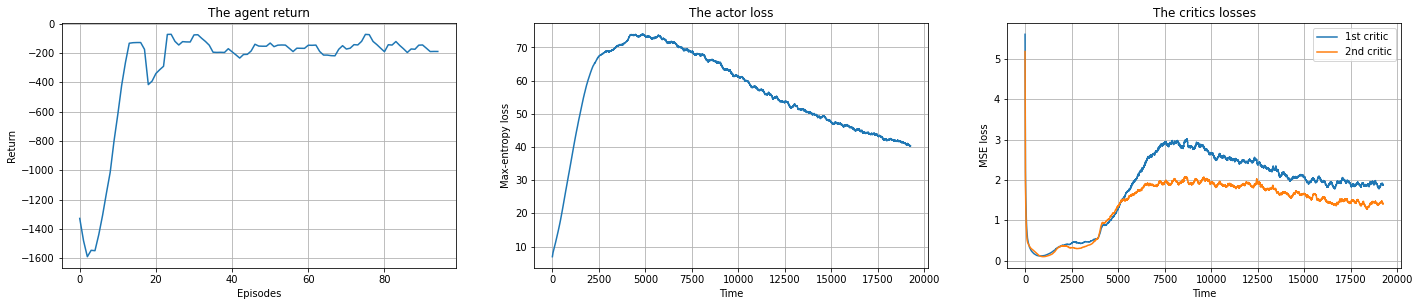

In [24]:
# Plot the result

def sliding_window(values, span):
    cumsum = np.cumsum(values)
    return (cumsum[span:] - cumsum[:-span]) / float(span)

nrows, ncols = 1, 3
dx, dy = 16, 9
scale = 1.5
figsize = plt.figaspect(float(dy * nrows) / float(dx * ncols)) * scale
plt.figure(figsize=figsize)

plt.subplot(nrows, ncols, 1)

plt.plot(sliding_window(ep_rets, 5))
plt.title('The agent return')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.grid()

plt.subplot(nrows, ncols, 2)

plt.plot(sliding_window(pi_losses, 200))
plt.title('The actor loss')
plt.xlabel('Time')
plt.ylabel('Max-entropy loss')
plt.grid()

plt.subplot(nrows, ncols, 3)

plt.plot(sliding_window(q1_losses, 200), label='1st critic')
plt.plot(sliding_window(q2_losses, 200), label='2nd critic')
plt.title('The critics losses')
plt.xlabel('Time')
plt.ylabel('MSE loss')
plt.legend()
plt.grid()

plt.show()

In [25]:
total_ret, total_len = 0, 0
for _ in range(num_test_episodes):
    o, d, ep_len = env.reset(), False, 0
    while not (d or (ep_len == max_ep_len)):
        # Take deterministic actions at test time.
        o, r, d, info = env.step(
            get_action(tf.convert_to_tensor(o), tf.constant(True)))
        total_ret += r
        ep_len += 1
    total_len += ep_len
print(f"TEST | Ep. length: {total_len/num_test_episodes:4}; Ep. return: {total_ret/num_test_episodes:4.0f};")

TEST | Ep. length: 200.0; Ep. return: -146;


In [26]:
envw = gym.wrappers.Monitor(env, "./", force=True)
o, d, ep_len = envw.reset(), False, 0
while not (d or (ep_len == max_ep_len)):
    envw.render()
    o, r, d, info = envw.step(
        get_action(tf.convert_to_tensor(o), tf.constant(True)))
envw.close()

In [27]:
import glob
file_name = glob.glob('openaigym.video.*.mp4')[0]
show_video(file_name)

# Homework

Run SAC on one of the MuJoCo environments using the implementation from https://github.com/awarelab/spinningup_tf2